In [15]:
import numpy as np
import time
import torch
import scipy.optimize as opt
import pywph as pw
import matplotlib.pyplot as plt

In [16]:
target = np.load('../CompSepAlgo/data/sim_QiU_stdr_3.npy')
test = np.load('examples/synthesis_real_only_256_moments4.npy')
test_new = np.load('examples/synthesis_real_only_256_moments6.npy')

In [17]:
target_256 = target.reshape(int(512/2), 2, int(512/2), 2).mean(axis=(1, 3))
np.save('./sim_QiU_stdr_3_256.npy', target_256)

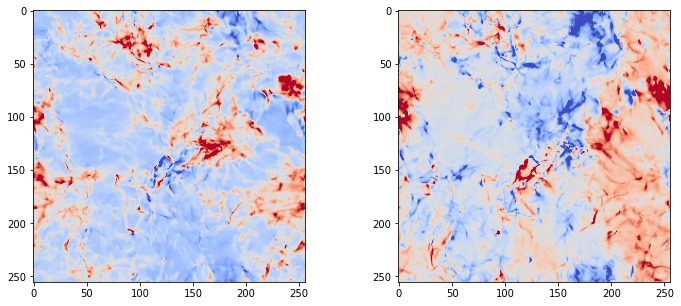

In [19]:
_ = plt.figure(figsize=(12,5))
_ = plt.subplot(1,2,1), plt.imshow(target_256.real, cmap='coolwarm', clim=(-1e-4,4e-4))
_ = plt.subplot(1,2,2), plt.imshow(target_256.imag, cmap='coolwarm', clim=(-2e-4,2e-4))

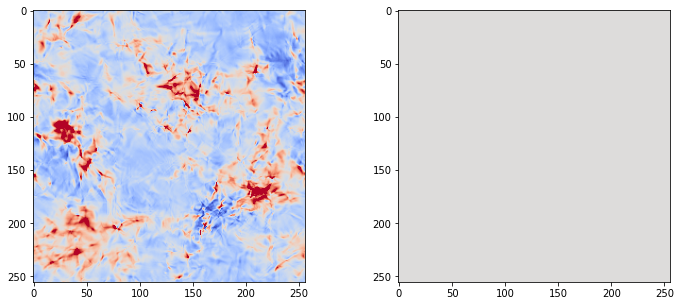

In [21]:
_ = plt.figure(figsize=(12,5))
_ = plt.subplot(1,2,1), plt.imshow(test.real, cmap='coolwarm', clim=(-1e-4,4e-4))
_ = plt.subplot(1,2,2), plt.imshow(test.imag, cmap='coolwarm', clim=(-2e-4,2e-4))

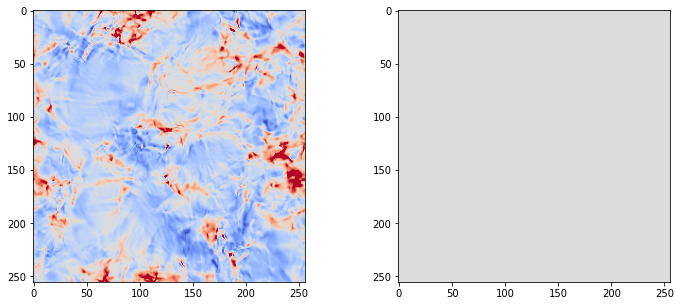

In [22]:
_ = plt.figure(figsize=(12,5))
_ = plt.subplot(1,2,1), plt.imshow(test_new.real, cmap='coolwarm', clim=(-1e-4,4e-4))
_ = plt.subplot(1,2,2), plt.imshow(test_new.imag, cmap='coolwarm', clim=(-2e-4,2e-4))

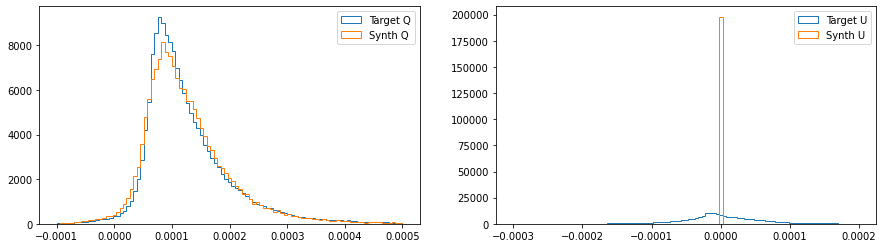

In [23]:
_ = plt.figure(figsize=(15,4)), plt.subplot(121)
_ = plt.hist(target.real.flatten(),
             bins=np.linspace(-1e-4,5e-4,100), histtype='step', label='Target Q',density=True)
_ = plt.hist(test.real.flatten(),
             bins=np.linspace(-1e-4,5e-4,100),density=True, histtype='step', label='Synth Q'), plt.legend()
_ = plt.subplot(122)
_ = plt.hist(target.imag.flatten(),
             bins=np.linspace(-3e-4,2e-4,100), histtype='step', label='Target U',density=True)
_ = plt.hist(test.imag.flatten(),
             bins=np.linspace(-3e-4,2e-4,100),density=True, histtype='step', label='Synth U'), plt.legend()

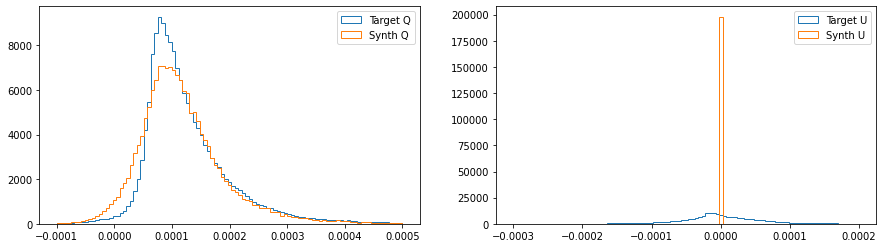

In [24]:
_ = plt.figure(figsize=(15,4)), plt.subplot(121)
_ = plt.hist(target.real.flatten(),
             bins=np.linspace(-1e-4,5e-4,100), histtype='step', label='Target Q',density=True)
_ = plt.hist(test_new.real.flatten(),
             bins=np.linspace(-1e-4,5e-4,100),density=True, histtype='step', label='Synth Q')
_ = plt.legend()
_ = plt.subplot(122)
_ = plt.hist(target.imag.flatten(),
             bins=np.linspace(-3e-4,2e-4,100), histtype='step', label='Target U',density=True)
_ = plt.hist(test_new.imag.flatten(),
             bins=np.linspace(-3e-4,2e-4,100),density=True, histtype='step', label='Synth U')
_ = plt.legend()

In [25]:

def radial_profile(data):
  """
  Compute the radial profile of 2d image
  :param data: 2d image
  :return: radial profile
  """
  center = data.shape[0]/2
  y, x = np.indices((data.shape))
  r = np.sqrt((x - center)**2 + (y - center)**2)
  r = r.astype('int32')

  tbin = np.bincount(r.ravel(), data.ravel())
  nr = np.bincount(r.ravel())
  radialprofile = tbin / nr
  return radialprofile

def measure_power_spectrum(map_data, pixel_size):
  """
  measures power 2d data
  :param power: map (nxn)
  :param pixel_size: pixel_size (rad/pixel)
  :return: ell
  :return: power spectrum
  
  """
  data_ft = np.fft.fftshift(np.fft.fft2(map_data)) / map_data.shape[0]
  nyquist = np.int(map_data.shape[0]/2)
  power_spectrum_1d =  radial_profile(np.real(data_ft*np.conj(data_ft)))[:nyquist] * (pixel_size)**2
  k = np.arange(power_spectrum_1d.shape[0])
  ell = 2. * np.pi * k / pixel_size / 360
  return ell, power_spectrum_1d

In [30]:
_, power_rescaled_target = measure_power_spectrum(target_256.real,1.)
_, power_rescaled_synth = measure_power_spectrum(test.real,1.)
_, power_rescaled_synth_new = measure_power_spectrum(test_new.real,1.)

/mesopsl3/home/njeffrey/wphenv/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


(None, <matplotlib.legend.Legend at 0x7fd60119a400>)

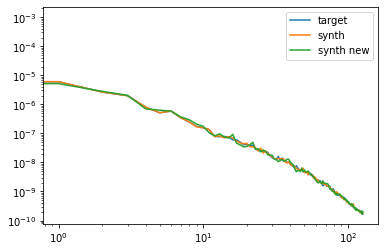

In [31]:
plt.loglog(power_rescaled_target, label='target')
plt.plot(power_rescaled_synth, label='synth')
plt.plot(power_rescaled_synth_new, label='synth new')
plt.yscale('log'), plt.legend()

(<matplotlib.legend.Legend at 0x7fd600cc3e48>, None)

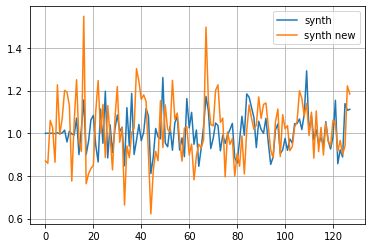

In [33]:
# plt.plot(power_rescaled_target, label='target')
plt.plot(power_rescaled_synth/power_rescaled_target, label='synth')
plt.plot(power_rescaled_synth_new/power_rescaled_target, label='synth new')
plt.legend(), plt.grid(True)